<a href="https://colab.research.google.com/github/skhazaei/TensorFlow-repo/blob/master/transfer_learning_cats_vs_dogs_with_dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download the weights that are trained on ImageNet

In [ ]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
-O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-02-14 14:19:14--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 108.177.127.128, 74.125.128.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  44.1MB/s    in 1.9s    

2021-02-14 14:19:16 (44.1 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



# Create an instance of perception_v3 

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3),
    weights = None,
    include_top = False
)

# Load the weights into the pre-trained model

In [ ]:
local_weights = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model.load_weights(local_weights)

# Lock the top layers of pre-trained model

In [ ]:
from tensorflow.keras import layers

for layer in pre_trained_model.layers:
  layer.trainable = False

# Get the summary of the pre-trained model

In [ ]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

# Determine which layer is going to be the last layer

In [ ]:
last_layer = pre_trained_model.get_layer('mixed7')
print ('shape of last layer: {}'.format(last_layer.output_shape))

shape of last layer: (None, 7, 7, 768)


# Convert last layer to the Tensor

In [ ]:
output_layer = last_layer.output

# Add dense layers to the model and define the model with pre trained features of ImageNet

In [ ]:
from tensorflow.keras import Model
import tensorflow as tf

x = layers.Flatten()(output_layer)
x = layers.Dense(1024, activation=tf.nn.relu)(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation = tf.nn.sigmoid)(x)

model = Model(pre_trained_model.input, x)

# Get the summary of the model

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Compile the model

In [ ]:
model.compile(optimizer = tf.optimizers.RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Train Cats vs Dogs using Transfer Learning with dropout

In [ ]:
# Download the dataset
!wget --no-check-certificate \
 https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip


import zipfile
# unzip the dataset
local_zip = '/tmp/cats_and_dogs_filtered.zip'
ref_zip = zipfile.ZipFile(local_zip, 'r')
ref_zip.extractall('/tmp')
ref_zip.close()


import os
# define the train and validation directories
base_dir = os.path.join('/tmp/cats_and_dogs_filtered')

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cats_fname = os.listdir(train_cats_dir)
train_dogs_fname = os.listdir(train_dogs_dir)

# Set up the image generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# add data augmentation parameter to the ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
    shear_range = 0.2,
    horizontal_flip = True
)

validation_datagen = ImageDataGenerator(rescale = 1./255.)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary'
)

--2021-02-14 14:56:21--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.128, 173.194.79.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  53.8MB/s    in 1.2s    

2021-02-14 14:56:23 (53.8 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
history = model.fit_generator(
    train_generator,
    validation_data = validation_generator,
    epochs = 100,
    steps_per_epoch = 100,
    validation_steps = 50,
    verbose = 2
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
100/100 - 27s - loss: 0.3458 - accuracy: 0.8680 - val_loss: 0.1217 - val_accuracy: 0.9470
Epoch 2/100
100/100 - 17s - loss: 0.2280 - accuracy: 0.9115 - val_loss: 0.1113 - val_accuracy: 0.9580
Epoch 3/100
100/100 - 18s - loss: 0.2141 - accuracy: 0.9225 - val_loss: 0.2693 - val_accuracy: 0.9170
Epoch 4/100
100/100 - 17s - loss: 0.1921 - accuracy: 0.9275 - val_loss: 0.0968 - val_accuracy: 0.9730
Epoch 5/100
100/100 - 17s - loss: 0.1800 - accuracy: 0.9405 - val_loss: 0.1341 - val_accuracy: 0.9530
Epoch 6/100
100/100 - 17s - loss: 0.1829 - accuracy: 0.9405 - val_loss: 0.1141 - val_accuracy: 0.9660
Epoch 7/100
100/100 - 17s - loss: 0.1570 - accuracy: 0.9505 - val_loss: 0.1125 - val_accuracy: 0.9650
Epoch 8/100
100/100 - 17s - loss: 0.1718 - accuracy: 0.9390 - val_loss: 0.0991 - val_accuracy: 0.9690
Epoch 9/100
100/100 - 17s - loss: 0.1835 - accuracy: 0.9420 - val_loss: 0.0961 - val_accuracy: 0.9690
Epoch 10/100
100/100 - 17s - loss: 0.1508 - accuracy: 0.9440 - val_loss: 0.1112 - 

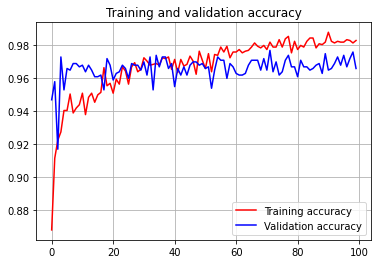

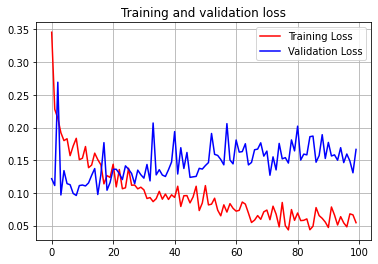

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r' , label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.grid()
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and validation loss')
plt.grid()
plt.legend()

plt.show()